In [1]:
import sys
import os
module_path = os.path.abspath('/media/jary/DATA/Uni/tesi/codice')
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
import networks.continual_learning as continual_learning
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import numpy as np

In [3]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [5]:
configOnline = configClasses.OnlineLearningConfig()
configOnline.L1_REG = 0
configOnline.EPOCHS = 20
configOnline.SAVE_PATH = './models/isolation_minst'
configOnline.IS_CONVOLUTIONAL = False
configOnline.USE_EWC = False
configOnline.OPTIMIZER = 'Adam'
print(configOnline)

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
OPTIMIZER: Adam
RUN_NAME: default
SAVE_PATH: ./models/isolation_minst
USE_EWC: False
USE_TENSORBOARD: True



In [6]:
dataset = MINST.MINST('../data/minst', download=True, task_manager=NoTask,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)


In [7]:
multikaf = Kafnet.MultiKAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7),  kaf_init_fcn=None,
                             trainable_dict=False, kernel_combination='sum', kernels=['gaussian', 'sigmoid', 'softplus'])
kaf = NoKafnet.MLP(len(dataset.class_to_idx))

In [8]:
experiments_multikaf = ['softmax', 'sum', 'sigmoid', 'neuron_attention']
results = []

def copy_weights(net1, net2):
    model_dict = net1.state_dict()
    pretrained_dict = {k: v for k, v in net2.state_dict().items() if 'dict' not in k and 'alpha' not in k}
    model_dict.update(pretrained_dict)
    return model_dict

In [9]:
for name in experiments_multikaf:
    print(name)
    n = Kafnet.MultiKAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7),  kaf_init_fcn=None,
                             trainable_dict=False, kernel_combination=name, kernels=['gaussian', 'sigmoid', 'softplus'])

    n.load_state_dict(copy_weights(n, multikaf))
    
    config = deepcopy(configOnline)
    
    config.MODEL_NAME = name

    trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

    r = trainer.load()
    if not r:
        r = trainer.all_tasks()
    
    results.append((name, r))
    
    del trainer
    del n

softmax
sum
sigmoid


Training task 0, epoch 1: 100%|██████████| 875/875 [00:17<00:00, 54.06it/s, loss=0.527, batch#=875]
Testing task 0: 219it [00:02, 80.40it/s, batch#=219]
Training task 0, epoch 2: 100%|██████████| 875/875 [00:16<00:00, 54.25it/s, loss=0.156, batch#=875]
Testing task 0: 219it [00:02, 84.30it/s, batch#=219]
Training task 0, epoch 3: 100%|██████████| 875/875 [00:16<00:00, 53.80it/s, loss=0.125, batch#=875]
Testing task 0: 219it [00:02, 84.12it/s, batch#=219]
Training task 0, epoch 4: 100%|██████████| 875/875 [00:16<00:00, 53.90it/s, loss=0.108, batch#=875] 
Testing task 0: 219it [00:02, 83.98it/s, batch#=219]
Training task 0, epoch 5: 100%|██████████| 875/875 [00:16<00:00, 53.95it/s, loss=0.09, batch#=875]  
Testing task 0: 219it [00:02, 83.86it/s, batch#=219]
Training task 0, epoch 6: 100%|██████████| 875/875 [00:16<00:00, 53.79it/s, loss=0.0865, batch#=875]
Testing task 0: 219it [00:02, 84.06it/s, batch#=219]
Training task 0, epoch 7: 100%|██████████| 875/875 [00:16<00:00, 53.55it/s, los

0 [0.9521428571428572, 0.9610714285714286, 0.9665714285714285, 0.9655, 0.9723571428571428, 0.966, 0.9668571428571429, 0.9717857142857143, 0.974, 0.9744285714285714, 0.9701428571428572, 0.9759285714285715, 0.9725, 0.9767857142857143, 0.9749285714285715, 0.9747857142857143, 0.9767857142857143, 0.9769285714285715, 0.9770714285714286, 0.9742142857142857]
neuron_attention


Training task 0, epoch 1: 100%|██████████| 875/875 [00:16<00:00, 52.52it/s, loss=0.294, batch#=875]
Testing task 0: 219it [00:02, 84.27it/s, batch#=219]
Training task 0, epoch 2: 100%|██████████| 875/875 [00:16<00:00, 52.36it/s, loss=0.134, batch#=875]
Testing task 0: 219it [00:02, 83.89it/s, batch#=219]
Training task 0, epoch 3: 100%|██████████| 875/875 [00:16<00:00, 52.46it/s, loss=0.0988, batch#=875]
Testing task 0: 219it [00:02, 84.21it/s, batch#=219]
Training task 0, epoch 4: 100%|██████████| 875/875 [00:16<00:00, 52.41it/s, loss=0.0893, batch#=875]
Testing task 0: 219it [00:02, 84.15it/s, batch#=219]
Training task 0, epoch 5: 100%|██████████| 875/875 [00:17<00:00, 51.19it/s, loss=0.0734, batch#=875]
Testing task 0: 219it [00:02, 80.96it/s, batch#=219]
Training task 0, epoch 6: 100%|██████████| 875/875 [00:17<00:00, 50.37it/s, loss=0.0653, batch#=875]
Testing task 0: 219it [00:02, 78.64it/s, batch#=219]
Training task 0, epoch 7: 100%|██████████| 875/875 [00:17<00:00, 50.47it/s, lo

0 [0.9610714285714286, 0.9651428571428572, 0.9692857142857143, 0.9727142857142858, 0.9724285714285714, 0.9768571428571429, 0.9739285714285715, 0.9711428571428572, 0.9747142857142858, 0.9770714285714286, 0.9772142857142857, 0.9758571428571429, 0.9780714285714286, 0.9750714285714286, 0.9766428571428571, 0.9782142857142857, 0.9766428571428571, 0.9747857142857143, 0.9763571428571428, 0.9777857142857143]


In [10]:
experiments_multikaf.append('kaf')
print('kaf')
n = deepcopy(kaf)

n.load_state_dict(copy_weights(n, kaf))

config = deepcopy(configOnline)

config.MODEL_NAME = 'kaf'

trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

r = trainer.load()
if not r:
    r = trainer.all_tasks()

results.append(('kaf', r))

del trainer
del n

kaf


In [11]:
print('RESULTS')
for name, r in results:
    print(name, r['metrics']['accuracy'])
    print()

RESULTS
softmax 0.9532142857142857

sum 0.9621428571428572

sigmoid 0.9742142857142857

neuron_attention 0.9777857142857143

kaf 0.9748571428571429



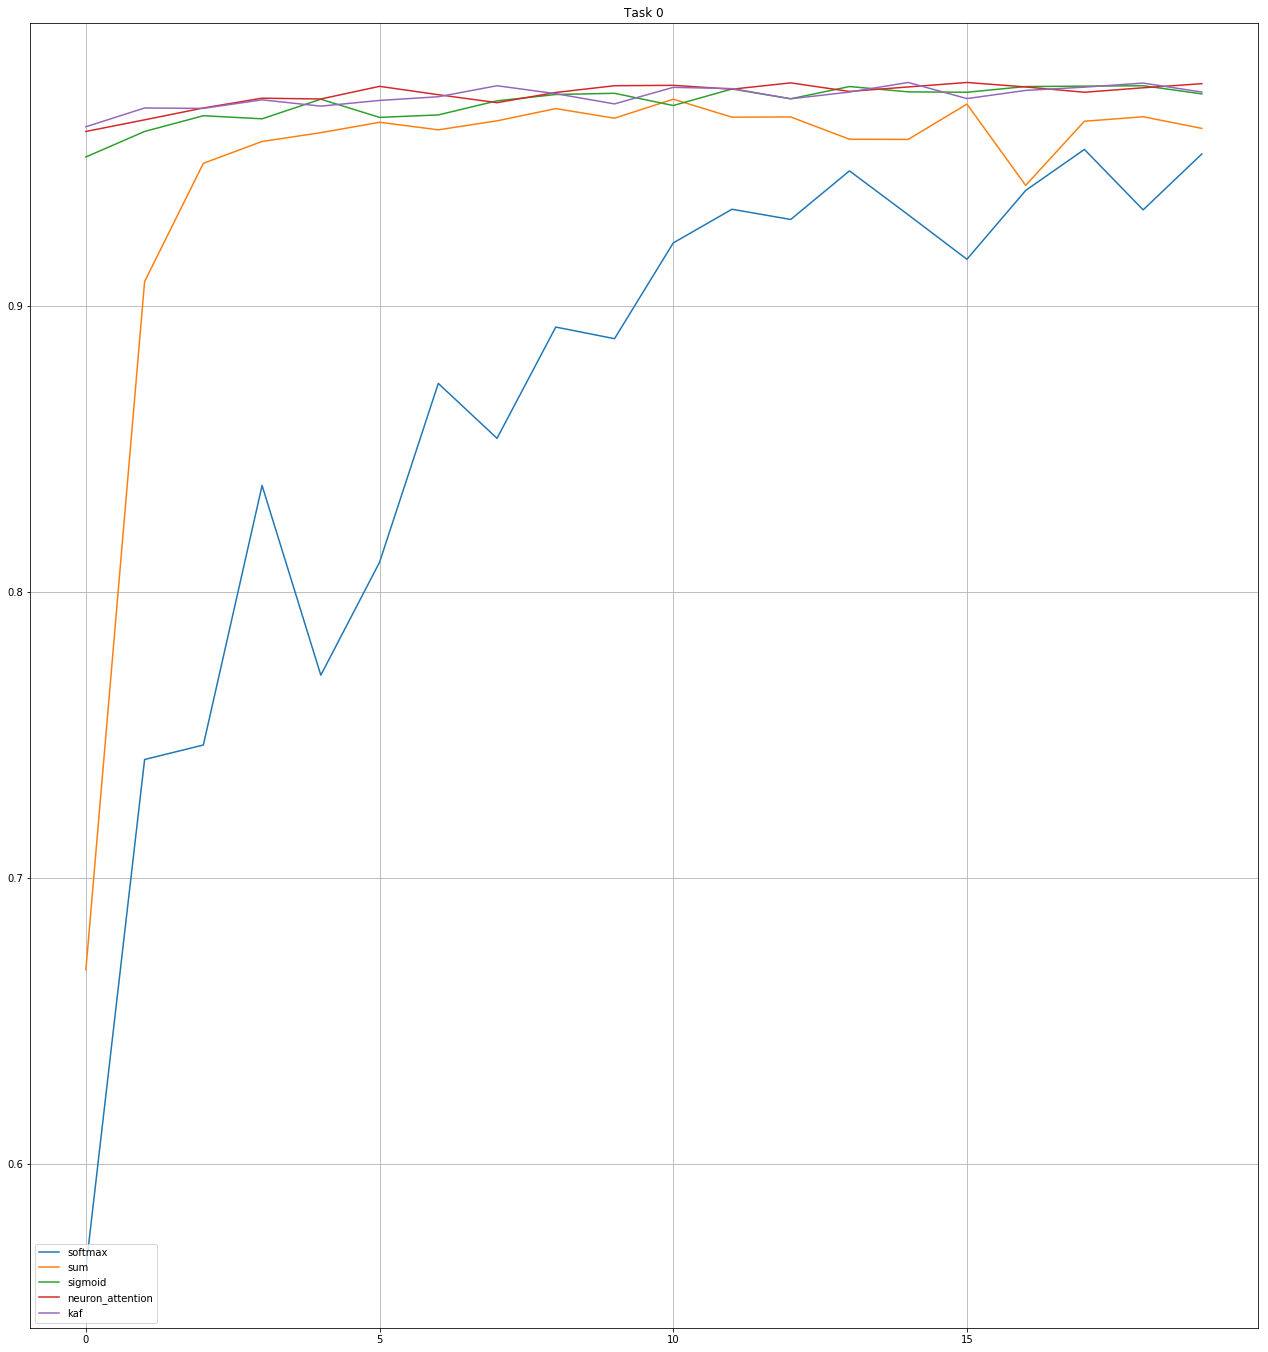

In [12]:
n_task = len(results[0][1]['tasks'])

tot_epochs = 0

for _, r in results:
    for k, v in r['tasks'].items():
        tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(22, 24), sharex=True, sharey=True)

for name, r in results:
    for i, task in enumerate(r['tasks'].keys()):

        com = r['tasks'][task]

        x = range(tot_epochs-len(com['accuracy']), tot_epochs)

        ax.plot(x, com['accuracy'], label=name)
        ax.set_xticks(range(0, tot_epochs, 5),minor=False)

        ax.set_title("Task {}".format(task))
        ax.legend(loc="lower left")
        ax.grid(True, axis='both')

        
fig.subplots_adjust(hspace=0.1, wspace=0.01)
